In [15]:
import comet_ml

from preprocessing import *
from model_custom_roberta import *

import argparse
import pandas as pd
import json

from transformers import RobertaConfig, get_scheduler
from roberta_config import CustomRobertaConfig
from accelerate import Accelerator, DistributedDataParallelKwargs
from torch.optim import AdamW
from datasets import load_dataset, load_metric
import copy
import matplotlib.pyplot as plt
import numpy as np

import pickle

# Architecture & Parameters

In [6]:
task = "cola"

with open("/home/lvpoellhuber/projects/benchmarkIR/src/lm/configs/test_finetune.json") as fp: 
    original_arg_dict = json.load(fp)
  
for key in original_arg_dict["settings"]:
    if type(original_arg_dict["settings"][key]) == str:
        original_arg_dict["settings"][key] = original_arg_dict["settings"][key].replace("STORAGE_DIR", STORAGE_DIR)

arg_dict = copy.deepcopy(original_arg_dict)

arg_dict["settings"]["task"] = task

arg_dict["settings"]["save_path"] = os.path.join(arg_dict["settings"]["save_path"], "roberta_"+task)  # Changed 'save_path' from 'model'

arg_dict["settings"]["dataset"] = os.path.join(arg_dict["settings"]["dataset"], os.path.join(task, task+"_train.pt"))


In [11]:
config_dict = arg_dict["config"]
settings = arg_dict["settings"]
dataset_path = settings["dataset"]

tokenizer = get_tokenizer("FacebookAI/roberta-base")


config = CustomRobertaConfig.from_dict(config_dict)
config.vocab_size = tokenizer.vocab_size
config.num_labels = 2


accelerator = Accelerator(log_with="comet_ml", kwargs_handlers=[DistributedDataParallelKwargs(find_unused_parameters=True)])
device = accelerator.device 

In [22]:
model = RobertaForSequenceClassification(config=config).from_pretrained("FacebookAI/roberta-base", config=config, ignore_mismatched_sizes=True)
model.to(device)

optim = AdamW(model.parameters(), lr=settings["lr"]) # typical range is 1e-6 to 1e-4

train_dataloader = get_dataloader(settings["batch_size"], dataset_path)

epochs = settings["epochs"]
num_training_steps = epochs * len(train_dataloader)
num_warmup_steps = int(0.06 * num_training_steps)

scheduler = get_scheduler(
    "linear", 
    optimizer=optim, 
    num_warmup_steps=num_warmup_steps, 
    num_training_steps=num_training_steps
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'roberta.encoder.layer.0.attention.self.distance_embedding.weight', 'roberta.encoder.layer.1.attention.self.distance_embedding.weight', 'roberta.encoder.layer.2.attention.self.distance_embedding.weight', 'roberta.encoder.layer.3.attention.self.distance_embedding.weight', 'roberta.encoder.layer.4.attention.self.distance_embedding.weight', 'roberta.encoder.layer.5.attention.self.distance_embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
optim

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0
    maximize: False
    weight_decay: 0.01
)

In [ ]:
checkpoint = torch.load("/home/lvpoellhuber/storage/models/new-attention/checkpoint", map_location='cuda:0')
model.load_state_dict(checkpoint["model_state_dict"])
optim.load_state_dict(checkpoint["optimizer_state_dict"])
#scheduler.load_state_dict(checkpoint["scheduler"])

/tmp/ipykernel_122322/2386852083.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/lvpoellhuber/storage/models/new-attention/checkpoint", ma

KeyError: 'scheduler'

In [24]:
model

RobertaForSequenceClassification(
  (roberta): CustomRobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(1027, 64)
            )
            (output): RobertaSelfOutput(
              (dense): Linear

# Gradient & Loss


In [2]:

class TrainingMonitor:
    def __init__(self, model):
        self.model = model
        self.step_metrics = []
    
    def log_step(self, batch, loss, step):
        # Collect gradient information
        grad_norms = {
            name: param.grad.norm().item()
            for name, param in self.model.named_parameters()
            if param.requires_grad and param.grad is not None
        }
        
        # Collect weight information
        weight_norms = {
            name: param.data.norm().item()
            for name, param in self.model.named_parameters()
            if param.requires_grad
        }
        
        # Store everything as native Python types for easy serialization
        self.step_metrics.append({
            'step': int(step),
            'loss': float(loss.item()),
            'grad_norms': {k: float(v) for k, v in grad_norms.items()},
            'weight_norms': {k: float(v) for k, v in weight_norms.items()}
        })
    
    def save_metrics(self, filepath):
        # Convert path to Path object for easier handling
        save_path = Path(filepath)
        
        # Create directory if it doesn't exist
        save_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Save the metrics using pickle
        with open(save_path, 'wb') as f:
            pickle.dump(self.step_metrics, f)
        
        print(f"Metrics saved to {save_path}")
    
    @classmethod
    def load_metrics(cls, filepath):
        # Load the metrics from file
        with open(filepath, 'rb') as f:
            loaded_metrics = pickle.load(f)
        
        # Create a new monitor instance
        monitor = cls(model=None)  # We don't need the model for loaded metrics
        monitor.step_metrics = loaded_metrics
        
        return monitor

In [3]:
# Load both sets of metrics
custom_monitor = TrainingMonitor.load_metrics('/home/lvpoellhuber/storage/custom_metrics.pkl')
trainer_monitor = TrainingMonitor.load_metrics('/home/lvpoellhuber/storage/trainer_df.pkl')

In [4]:
# Convert to pandas DataFrames for easier analysis
def metrics_to_df(metrics):
    # Extract basic metrics
    df = pd.DataFrame([{
        'step': m['step'],
        'loss': m['loss']
    } for m in metrics])
    
    # Add gradient norms as separate columns
    for step_metric in metrics:
        for param_name, grad_norm in step_metric['grad_norms'].items():
            df.loc[df['step'] == step_metric['step'], f'grad_{param_name}'] = grad_norm
    
    return df

custom_df = metrics_to_df(custom_monitor.step_metrics)
trainer_df = metrics_to_df(trainer_monitor.step_metrics)


/tmp/ipykernel_788/3312751813.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['step'] == step_metric['step'], f'grad_{param_name}'] = grad_norm
/tmp/ipykernel_788/3312751813.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['step'] == step_metric['step'], f'grad_{param_name}'] = grad_norm
/tmp/ipykernel_788/3312751813.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at 

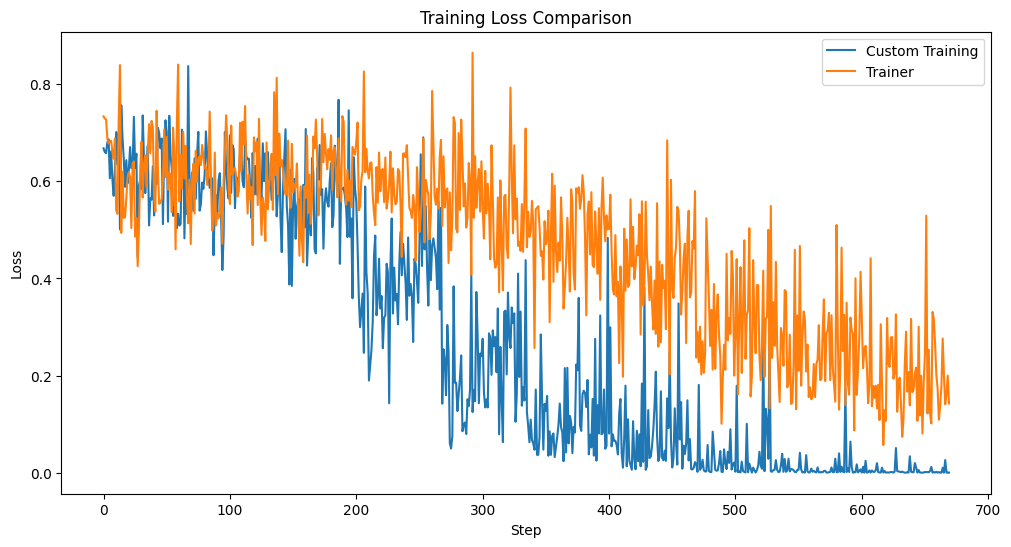

In [6]:

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(custom_df['step'], custom_df['loss'], label='Custom Training')
plt.plot(trainer_df['step'], trainer_df['loss'], label='Trainer')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

In [7]:

# Print summary statistics
print("\nLoss Statistics:")
print("Custom Training:")
print(custom_df['loss'].describe())
print("\nTrainer:")
print(trainer_df['loss'].describe())


Loss Statistics:
Custom Training:
count    670.000000
mean       0.264461
std        0.254901
min        0.000267
25%        0.013701
50%        0.163391
75%        0.530721
max        0.836633
Name: loss, dtype: float64

Trainer:
count    670.000000
mean       0.466272
std        0.176867
min        0.057222
25%        0.319805
50%        0.512492
75%        0.601556
max        0.864200
Name: loss, dtype: float64


In [14]:
scale = []
# Compare gradient norms
grad_columns = [col for col in custom_df.columns if col.startswith('grad_')]
for col in grad_columns:
    print(f"\nGradient statistics for {col}:")
    print("Custom Training:")
    custom_desc = custom_df[col].describe()
    print(custom_desc)
    print("\nTrainer:")
    trainer_desc = trainer_df[col.replace("grad_module.roberta", "grad_roberta").replace("grad_module.classifier", "grad_classifier")].describe()
    print(trainer_desc)

    
    col_scale = trainer_desc.loc["50%"] / custom_desc.loc["50%"]
    print("Median scale difference")
    print(col_scale)
    scale.append(col_scale)


Gradient statistics for grad_module.roberta.embeddings.word_embeddings.weight:
Custom Training:
count    670.000000
mean       0.213792
std        0.197171
min        0.001901
25%        0.039886
50%        0.171986
75%        0.350827
max        1.471179
Name: grad_module.roberta.embeddings.word_embeddings.weight, dtype: float64

Trainer:
count    670.000000
mean       0.293675
std        0.264539
min        0.003415
25%        0.020168
50%        0.235547
75%        0.529295
max        1.048089
Name: grad_roberta.embeddings.word_embeddings.weight, dtype: float64
Median scale difference
1.3695728277437456

Gradient statistics for grad_module.roberta.embeddings.position_embeddings.weight:
Custom Training:
count    670.000000
mean       0.218871
std        0.204079
min        0.001817
25%        0.040394
50%        0.171637
75%        0.360820
max        1.520512
Name: grad_module.roberta.embeddings.position_embeddings.weight, dtype: float64

Trainer:
count    670.000000
mean       0.3

# Data

In [50]:
with open("/home/lvpoellhuber/storage/trainer_batch.pkl", 'rb') as f:
    trainer_batch = pickle.load(f)

with open("/home/lvpoellhuber/storage/custom_batch.pkl", 'rb') as f:
    custom_batch = pickle.load(f)

/home/lvpoellhuber/env/bmir-env/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [51]:

class TextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        del self.encodings["sequence"]
        
    def __len__(self):
        return self.encodings["input_ids"].shape[0]
    
    def __getitem__(self, i):
        return  {key: tensor[i] for key, tensor in self.encodings.items()}
    
    def save(self, save_path):
        torch.save(self.encodings, save_path)
    

def get_dataloader(batch_size, dataset_path):
    dataset = TextClassificationDataset(torch.load(dataset_path))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle=False)
    
    return dataloader

torch.manual_seed(42)

In [52]:
my_dataloader = get_dataloader(32, "/home/lvpoellhuber/storage/datasets/cola/cola_train.pt")
my_batch = next(iter(my_dataloader))


/tmp/ipykernel_788/2828515017.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = TextClassificationDataset(torch.load(dataset_path))


In [54]:
trainer_batch

{'input_ids': tensor([[30522, 23873,  4985,  ..., 30525, 30525, 30525],
         [30522, 11567,   843,  ..., 30525, 30525, 30525],
         [30522, 11567,   843,  ..., 30525, 30525, 30525],
         ...,
         [30522, 24047, 26774,  ..., 30525, 30525, 30525],
         [30522,  7653,   298,  ..., 30525, 30525, 30525],
         [30522, 24270, 15156,  ..., 30525, 30525, 30525]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')}

In [55]:
custom_batch

{'input_ids': tensor([[30522, 23873,  4985,  ..., 30525, 30525, 30525],
         [30522, 11567,   843,  ..., 30525, 30525, 30525],
         [30522, 11567,   843,  ..., 30525, 30525, 30525],
         ...,
         [30522, 24047, 26774,  ..., 30525, 30525, 30525],
         [30522,  7653,   298,  ..., 30525, 30525, 30525],
         [30522, 24270, 15156,  ..., 30525, 30525, 30525]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 1, 1, 1])}

In [72]:
torch.all(trainer_batch["input_ids"].cpu() == custom_batch["input_ids"])

tensor(True)